This notebook is created during Vincent's Lab RETTL Project Summer 2022 by Tianze (Steven) Shou 

In this notebook, we are going to take `detector_results.csv` and aggregate the data by `studentID` to summarize each student's struggle, system misuse, gaming, and idleness status. We are also going to summarize teacher's help offered to each student, each student's help seeking pattern (raising hands) from `observation_events.tsv`. Eventually we are going to put them together to see if these variables pertain any correlation. 

In [25]:
# python setup 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import import_ipynb
from tutor_log_summary_stat import *
import detectorDataAPI as detectorAPI 

# 1. Data Aggregation 

We are going to aggregate all extracted data into `analyticsDF` for further analysis. 

In [9]:
# file loading 
detectorDF = pd.read_csv("output_files/detector_results.csv", index_col=False) 

obsEventsDF = pd.read_csv("output_files/event_master_file_D10_R500_RNG1000_sprint2_shou.csv", index_col=False)
obsEventsDF = obsEventsDF.loc[obsEventsDF["modality"] == "observation"]

# using rng=1000 here 
stopsDF = pd.read_csv("output_files/event_master_file_D10_R500_RNG1000_sprint2_shou.csv", index_col=False) 
stopsDF = stopsDF.loc[stopsDF["event"] == "Stopping"]
stopsDF.index = np.arange(len(stopsDF))

## 1.1 Extracting Hand-Raises and On-Task Teacher-Visits From Observation

In [10]:
def isValidStudID(studID) -> bool: 
    if not isinstance(studID, str): return False 
    return studID[:4] == "Stu_"

# extract number of teacher visits and number of hand raises by studentID, periodID, and dayID from observation events 
if __name__ == "__main__": 

    # structure of these mapping: (dayID, periodID, studID): number of 
    # teahcer-visit/hand-raises during the day/period for the given student 
    teacherVisitMapping = dict() 
    handRaisesMapping = dict() 

    for i in obsEventsDF.index: 

        event = obsEventsDF.loc[i, "event"] 
        isVisitEvent = (event == "Talking to student: ON-task" or 
                        event == "Talking to small group: ON-task") 
        isHandRaiseEvent = (event == "Raising hand")

        # ensure this row's "subject" value is string, not NaN
        if isinstance(obsEventsDF.loc[i, "subject"], str): 
            subjects = obsEventsDF.loc[i, "subject"].split(";")
        else: 
            subjects = []
        
        actor = obsEventsDF.loc[i, "actor"] 
        periodID, dayID = obsEventsDF.loc[i, "periodID"], obsEventsDF.loc[i, "dayID"]

        # valid visit event with valid student as subject, add 1 to count 
        for subject in subjects:
            if isVisitEvent and isValidStudID(subject): 
                teacherVisitMapping[(dayID, periodID, subject)] = teacherVisitMapping.get((dayID, periodID, subject), 0) + 1 

        # valid hand-raising event with valid student as actor, add 1 to count
        if isHandRaiseEvent and isValidStudID(actor): 
            handRaisesMapping[(dayID, periodID, actor)] = handRaisesMapping.get((dayID, periodID, actor), 0) + 1 

    # transform mappings into dataframes 
    dayID = [ key[0] for key in teacherVisitMapping ] 
    periodID = [ key[1] for key in teacherVisitMapping ] 
    studentID = [ key[2] for key in teacherVisitMapping ] 
    totalTeacherVisits = [ teacherVisitMapping[key] for key in teacherVisitMapping ] 
    teacherVisitDF = pd.DataFrame({"dayID": dayID, 
                                   "periodID": periodID, 
                                   "studentID": studentID, 
                                   "totalOnTaskTeacherVisits": totalTeacherVisits}) 

    # do the same to hand raises 
    dayID = [ key[0] for key in handRaisesMapping ] 
    periodID = [ key[1] for key in handRaisesMapping ] 
    studentID = [ key[2] for key in handRaisesMapping ] 
    totalHandRaises = [ handRaisesMapping[key] for key in handRaisesMapping ] 
    handRaisesDF = pd.DataFrame({"dayID": dayID, 
                                 "periodID": periodID, 
                                 "studentID": studentID, 
                                 "totalHandRaises": totalHandRaises}) 

    # outer join teahcer-vists and hand-raises dataframe 
    analyticsDF = pd.merge(teacherVisitDF, handRaisesDF, 
                           on=["dayID", "periodID", "studentID"], how="outer")

    
    
    # just met with Shamya, and should start with splitting by student, ignoring day and period 
    analyticsDF = analyticsDF.groupby(by=["studentID"]).sum()
    analyticsDF = analyticsDF.drop(["dayID", "periodID"], axis=1)

## 1.2 Extracting In-Range Stops from Position Events

In [11]:

def mapping2DF(mapping: dict, valueColumnName: str): 
    """
    Taking in mapping where (dayID, periodID, studentID) -> some_value, this function return a 
    pandas dataframe with each row corresponding to each key-value pair

    Args:
        mapping (dict): hash dictionary mapping with key-value pairs in the form: (dayID, periodID, studentID) -> some_value
        valueColumnName (str): column name for the value column 

    Returns:
        pandas.Dataframe: a pandas dataframe holding all entries in the mapping 
    """

    dayID = [key[0] for key in mapping]
    periodID = [key[1] for key in mapping] 
    studentID = [key[2] for key in mapping] 
    value = [ mapping[key] for key in mapping ] 

    DF = pd.DataFrame({"dayID": dayID, 
                       "periodID": periodID, 
                       "studentID": studentID, 
                       valueColumnName: value}) 

    return DF 

def oneKeyMappingToDF(mapping: dict, colName: str): 
    """
    Transform a dictionary mapping into a pandas dictionary. Mapping's keys must 
    be of length one, meaning that keys should not be tuples 
    """

    studentID = [ key for key in mapping ] 
    val = [ mapping[key] for key in mapping ] 

    return pd.DataFrame({"studentID": studentID, 
                         colName: val})

if __name__ == "__main__": 

    # structure of these mapping: studID: time length of 
    # stops during the day/period for the given student 
    stopsMapping = dict() 
    currStopStart = None # current stop starting time stamp
    for i in stopsDF.index: 

        if i == 0: currStopStart = stopsDF.loc[i, "timestamp"] 

        # this signals that indexing has jumped to the next stop
        elif stopsDF.loc[i, "content"] != stopsDF.loc[i-1, "content"]: 

            studentID = stopsDF.loc[i-1, "subject"] 
            dayID = stopsDF.loc[i-1, "dayID"] 
            periodID = stopsDF.loc[i-1, "periodID"] 
            currStopEnd = stopsDF.loc[i-1, "timestamp"] 

            if isValidStudID(studentID): # studentID must not be NaN 
                # add current stop length (currStopEnd - currStopStart) to mapping 
                currStopLength = currStopEnd - currStopStart
                stopsMapping[studentID] = stopsMapping.get(studentID, []) + [currStopLength]

            # update the starting time of current stop 
            currStopStart = stopsDF.loc[i, "timestamp"] 

        # this signals that indexing is still within the same stop 
        else: pass

    studentID = [ key for key in stopsMapping ]
    totalStopLength = [ sum(stopsMapping[key]) for key in stopsMapping ] 
    stopsLengthMean = [ np.mean(stopsMapping[key]) for key in stopsMapping ] 
    stopsLengthStd = [ np.std(stopsMapping[key]) for key in stopsMapping ] 
    stopsLengthMin = [ min(stopsMapping[key]) for key in stopsMapping ] 
    stopsLengthMax = [ max(stopsMapping[key]) for key in stopsMapping ] 
    
    studentStopDF = pd.DataFrame({"studentID": studentID, 
                                  "totalStopLength": totalStopLength, 
                                  "stopsLengthMean": stopsLengthMean, 
                                  "stopsLengthStd": stopsLengthStd, 
                                  "stopsLengthMin": stopsLengthMin, 
                                  "stopsLengthMax": stopsLengthMax}) 
    # merge with analyticsDF 
    analyticsDF = pd.merge(analyticsDF, studentStopDF, 
                           on=["studentID"], how="outer")



## 1.3 Extracting Off-Task Teach Visits from Observation 

In [12]:
if __name__ == "__main__": 

    StudID2OffTaskConvMapping = dict() 

    for i in obsEventsDF.index: 
        
        # filter out the off task conversations 
        if "off-task" in obsEventsDF.loc[i, "event"].lower(): 
            studentIDs = obsEventsDF.loc[i, "subject"].split(';') 

            # increment each student's number of off-task visit in the subject list
            for studentID in studentIDs: 
                if isValidStudID(studentID): 
                    StudID2OffTaskConvMapping[studentID] = StudID2OffTaskConvMapping.get(studentID, 0) + 1

    # transform mapping to dataframe and outer join with analyticsDF 
    offTaskConvDF = oneKeyMappingToDF(StudID2OffTaskConvMapping, "totalOffTaskTeacherVisits") 
    analyticsDF = pd.merge(offTaskConvDF, analyticsDF, on="studentID", how="outer")


## 1.4 Extracting Tutor Statistics 

Things to be extracted: overall performance for each student (# of correct attempts / (# of correct + # of incorrect + # of hints)), KC level performance, number of hints requested, number of problems finished, number of steps involved, time taken per step. 

In [13]:
# load tutor data, this function getAnnotatedTutorLogDF() is from tutor_log_summary_stat.ipynb
if __name__ == "__main__": 
    tutorLogDF = getAnnotatedTutorLogDF() 

<string>:15: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.


In [14]:
if __name__ == "__main__": 

    # all the unique student id's
    students = tutorLogDF["Anon Student Id"].unique().tolist() 

    # setup KC level performance column names 
    KCNames = pd.Series(['cancel-const', 'division-simple', 'divide',
                         'subtraction-const', 'combine-like-const', 'subtraction-var',
                         'combine-like-var', 'cancel-var', 'distribute-division',
                         'division-complex']) 
    KCPerformanceColNames = KCNames + "Performance" 
    KCPerformanceColNames = KCPerformanceColNames.tolist() 

    # setup tutor summary stat dataframe, index is by student ID 
    tutorSummaryDF = pd.DataFrame(columns=["overallPerformance", "hintRequested", 
                                           "problemsSolved", "totalSteps", 
                                           "timePerStep"] + KCPerformanceColNames, 
                                           index=students) 

    # extract individual student performance statistics 
    for studentID in tutorSummaryDF.index: # since this dataframe is indexed by studentID 
        # overall performance 
        tutorSummaryDF.loc[studentID, "overallPerformance"] = getStudentPerformanceSummary(tutorLogDF, students=[studentID]) 
        # number of hints 
        tutorSummaryDF.loc[studentID, "hintRequested"] = getNumOfHints(tutorLogDF, students=[studentID]) 
        # number of problems solved 
        tutorSummaryDF.loc[studentID, "problemsSolved"] = getNumOfProblemsSolved(tutorLogDF, students=[studentID]) 
        # number of steps 
        tutorSummaryDF.loc[studentID, "totalSteps"] = getNumOfSteps(tutorLogDF, students=[studentID]) 
        # avearge time taken per step 
        tutorSummaryDF.loc[studentID, "timePerStep"] = getTimePerStep(tutorLogDF, students=[studentID]) 
        # get KC level performance for each student 
        studentKCPerformanceMapping = getKCLevelPerformance(tutorLogDF, students=[studentID], suffix="Performance") 
        for colName in studentKCPerformanceMapping: 
            tutorSummaryDF.loc[studentID, colName] = studentKCPerformanceMapping[colName] 




In [15]:
# outer join tutor summary data for each student with analyticsDF 
if __name__ == "__main__": 
    tutorSummaryDF["studentID"] = tutorSummaryDF.index
    analyticsDF = pd.merge(analyticsDF, tutorSummaryDF, on="studentID", how="outer")

## 1.5 Extracting Number of Seconds Each Student being under Each Status Given by Detectors

Here we are going to extract these statistics with the help of `detectorDataAPI.py`. 

In [16]:
if __name__ == "__main__": 

    detectorDF = detectorAPI.getDetectorResultsDF() # get detector results dataframe 
    studentIDs = detectorDF["studentID"].unique().tolist() # all unique studentID's in detector results 

    detectorSummaryDF = pd.DataFrame(columns=["idle", "struggle", "gaming", "misuse"], 
                                     index=studentIDs) 

    # get each detector's result for each student
    for detectorName in detectorSummaryDF.columns: 
        for studentID in studentIDs: 
            # get time under status specified by detector for given student 
            detectorSummaryDF.loc[studentID, detectorName] = detectorAPI.getStudentStatusDurationByDetector(detectorDF, 
                                                                                                            detectorName, 
                                                                                                            studentID) 

    detectorSummaryDF["studentID"] = detectorSummaryDF.index 

    # get rid of outlier students 
    for col in ["idle", "struggle", "gaming", "misuse"]: 
        detectorSummaryDF = detectorSummaryDF.loc[detectorSummaryDF[col] < 5000]


In [17]:
# merging detector summary with analytics DF
if __name__ == "__main__": 
    analyticsDF = pd.merge(analyticsDF, detectorSummaryDF, on="studentID", how="outer") 

## 1.6 Pre and Post Testing Scores 

In [18]:
def actualID2AnonID(actualID, IDMapping): 
    
    entries = IDMapping.loc[IDMapping["actual_user_id"] == actualID]
    if len(entries) < 1: return np.nan 

    anonID = entries.iloc[0].loc["anon_user_id"] 
    return anonID

if __name__ == "__main__": 

    prePostScoresDF = pd.read_csv("raw data/WVW_pre_post_scores.csv", index_col=False)
    IDMapping = pd.read_csv("output_files/student_position_sprint1_shou.csv", index_col=False)
    # change the `greencat` id's to anon id's like Stu_xxxxxxxxxxxx
    prePostScoresDF["Anon Student Id"] = prePostScoresDF["Anon Student Id"].apply(actualID2AnonID, IDMapping=IDMapping)
    # get rows only with valid anon id's
    prePostScoresDF = prePostScoresDF.loc[prePostScoresDF["Anon Student Id"].notnull()]
    prePostScoresDF.index = np.arange(len(prePostScoresDF))

    # calculate the vector for learning gain 
    PfullScore = 5
    CfullScore = 16
    PlearningGain = (prePostScoresDF["pk"] - prePostScoresDF["pk_pre"]) / (PfullScore - prePostScoresDF["pk_pre"]) 
    ClearningGain = (prePostScoresDF["ck"] - prePostScoresDF["ck_pre"]) / (CfullScore - prePostScoresDF["ck_pre"]) 

    learningGainDF = pd.DataFrame({"studentID": prePostScoresDF["Anon Student Id"], 
                                   "PlearningGain": PlearningGain, 
                                   "ClearningGain": ClearningGain}) 
    analyticsDF = pd.merge(analyticsDF, learningGainDF, on="studentID", how="outer") 

# 2. Filling Missing Values and Create Features Based on Given Features 

In [19]:
if __name__ == "__main__":
    # columns that can be filled with zero's
    for col in ["totalOnTaskTeacherVisits", "totalOffTaskTeacherVisits", 
                "totalHandRaises", "totalStopLength", "stopsLengthMean", 
                "stopsLengthMax", "stopsLengthMin", "stopsLengthStd", 
                "idle", "struggle", "gaming", "misuse"]: 
        analyticsDF[col] = analyticsDF[col].fillna(0)

    # learning gain is filled with mean 
    # learningGainMean = np.mean(analyticsDF["learningGain"]) 
    # analyticsDF["learningGain"] = analyticsDF["learningGain"].fillna(learningGainMean) 

    # filter out students with very minimal attempt in tutor 
    analyticsDF = analyticsDF.loc[analyticsDF["overallPerformance"].notnull()] 

    # create number of hint per step 
    analyticsDF["hintPerStep"] = analyticsDF["hintRequested"] / analyticsDF["totalSteps"] 

    # get rid of outliers 
    analyticsDF = analyticsDF.loc[analyticsDF["timePerStep"] < 500]

# 3. Visualization 

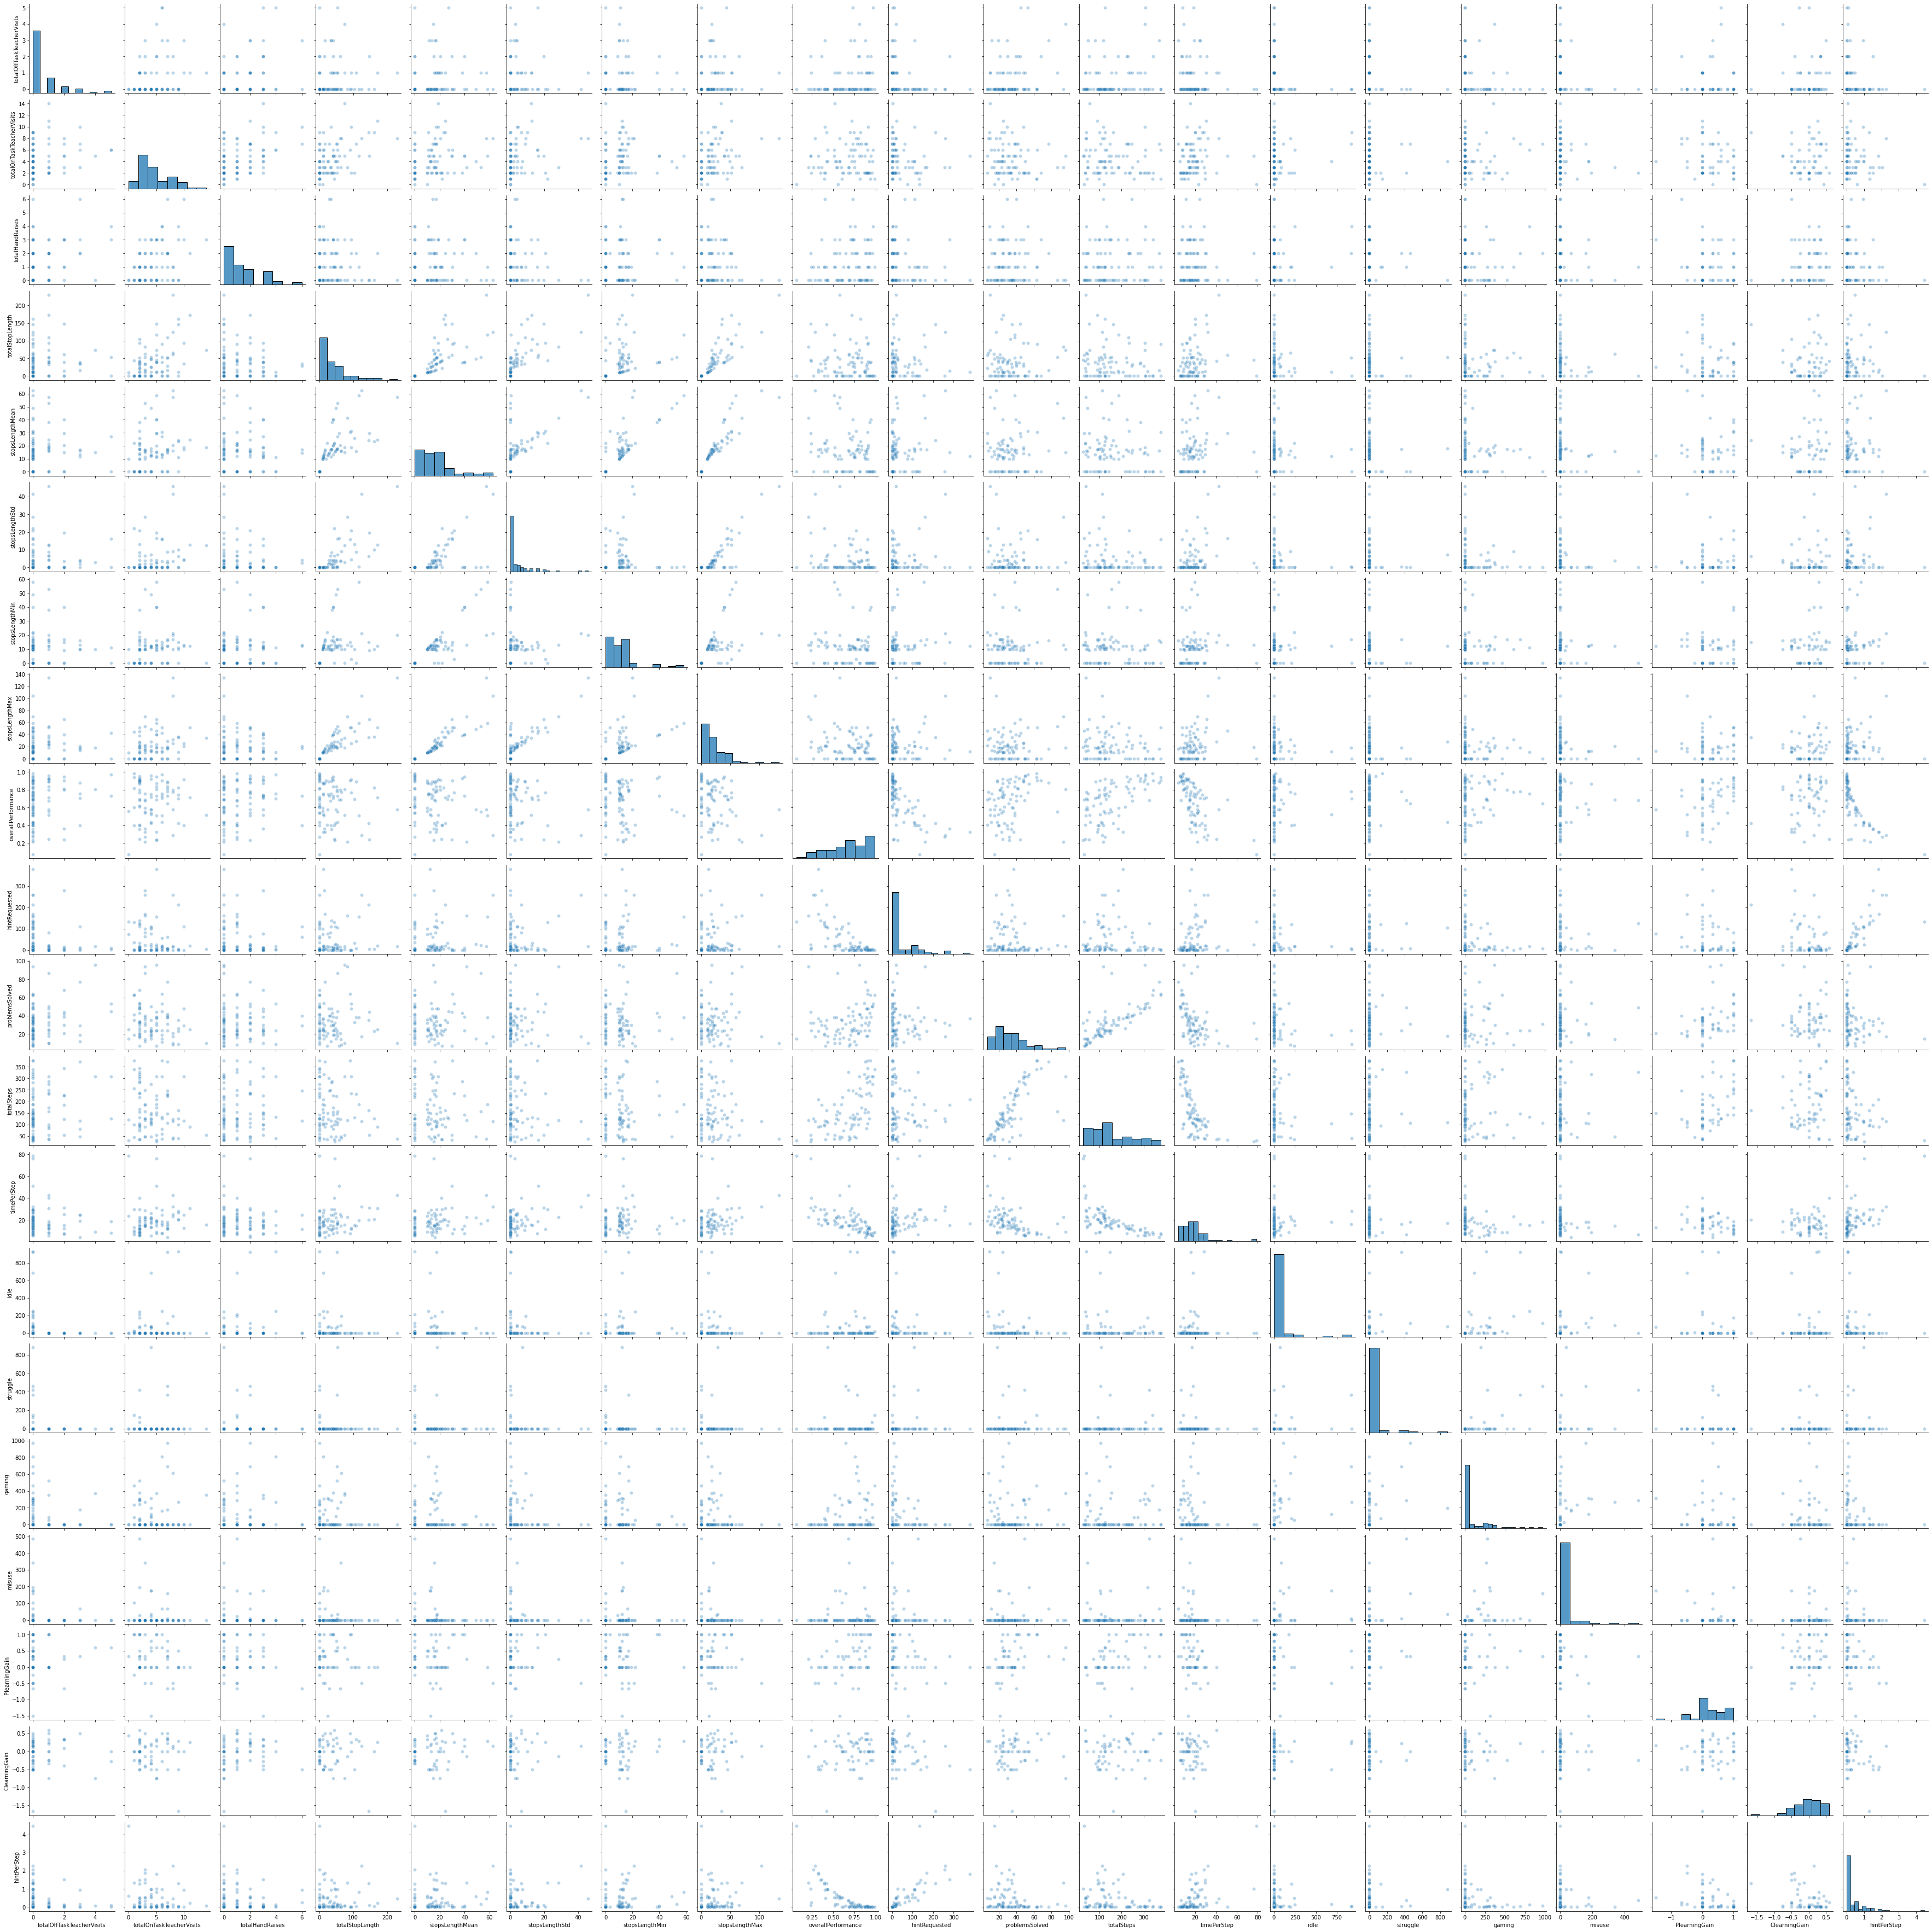

In [20]:
runPairsPlot = True
if __name__ == "__main__" and runPairsPlot:   
    visualDF = analyticsDF.drop(columns=["studentID"] + KCPerformanceColNames)
    sns.pairplot(visualDF, kind='scatter', plot_kws={'alpha':0.3}) 


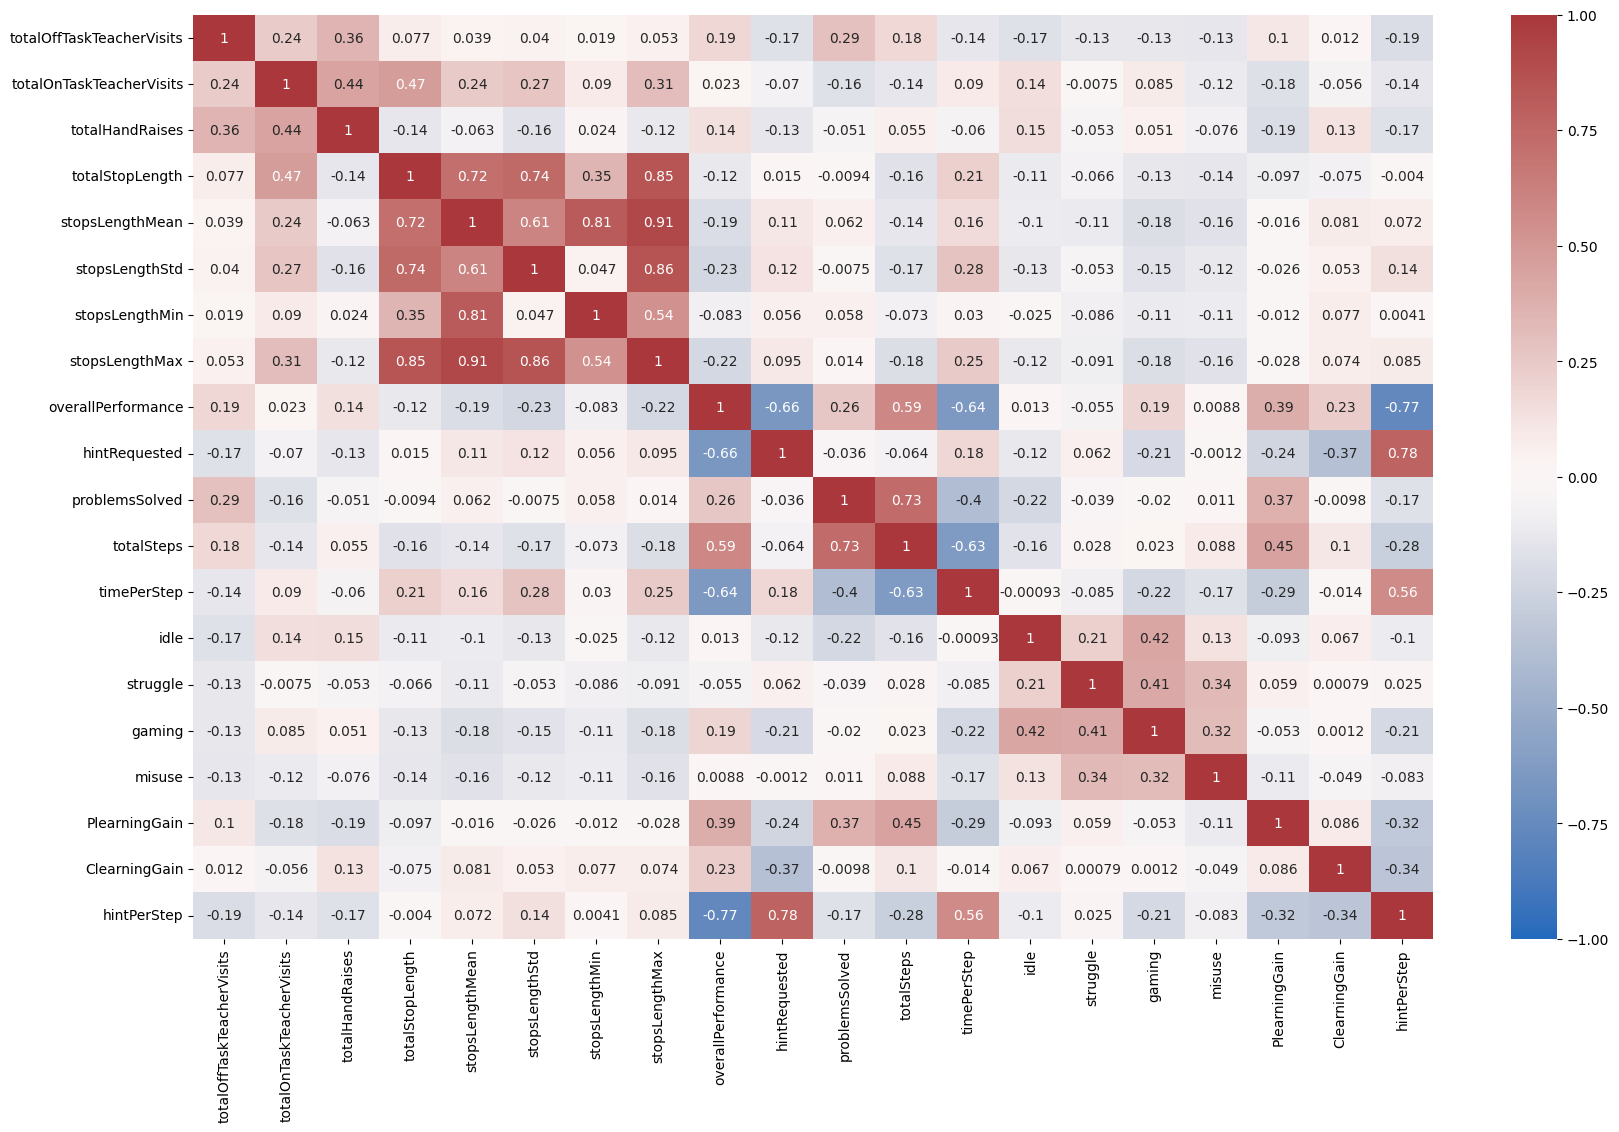

In [31]:
if __name__ == "__main__" and runPairsPlot: 

    # transform all columsn into numeric 
    for col in visualDF.columns: 
        visualDF[col] = pd.to_numeric(visualDF[col])

    corrMatrix = visualDF.corr()
    plt.rcParams["figure.figsize"] = (20,12)
    sns.heatmap(corrMatrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
    plt.show()

# 4. Linear Regression Between Variable Pairs and Visualization 

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 


def runLinRegAndVisualSingleX(x, y): 

    x = np.asarray(x).astype(np.float64) 
    y = np.asarray(y).astype(np.float64) 

    # add constant to predictor variables
    x = sm.add_constant(x)
    # fit linear regression model
    model = sm.OLS(y, x) 
    result = model.fit()

    #view model summary
    print(result.summary()) 

    #define figure size
    fig = plt.figure(figsize=(12,8))

    #produce residual plots
    fig = sm.graphics.plot_regress_exog(result, "x1", fig=fig)


def runLinRegAndVisual(data: pd.DataFrame, X: list, y: str, visualXName: str=""): 

    assert len(X) > 0 
    if visualXName == "": visualXName = X[0] 
    else: 
        assert visualXName in X, "X label for visualization is not in predictor list"

    df = data.copy()
    # organize data type
    for col in X + [y]: 
        assert col in df.columns, f"Variable name <{col}> in present in data" 
        df[col] = np.asarray(df[col]).astype(np.float64)

    # get formula for the model
    Xstr = ""
    for x in X: 
        Xstr += x + " + "
    Xstr = Xstr[:len(Xstr)-3]
    formula = y + " ~ " + Xstr

    # fit model and get result 
    model = smf.ols(formula, df) 
    result = model.fit() 

    #view model summary
    print(result.summary()) 

    #define figure size
    fig = plt.figure(figsize=(12,8))

    #produce residual plots
    fig = sm.graphics.plot_regress_exog(result, visualXName, fig=fig)


## 4.1 Predicting In-System Performance

Conclusions from the linear model below: 

- Overall performance can be well predicted by in-system performance

- `Average time taken per step` and `total number of hint requested` are the two most importance predictors 

- ~ 70% of the variance in `overall perforamnce` is being accounted for by these two predictors 

                            OLS Regression Results                            
Dep. Variable:     overallPerformance   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     104.9
Date:                Wed, 10 Aug 2022   Prob (F-statistic):           3.32e-23
Time:                        14:11:34   Log-Likelihood:                 60.486
No. Observations:                  84   AIC:                            -115.0
Df Residuals:                      81   BIC:                            -107.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.9304      0.025     37.966

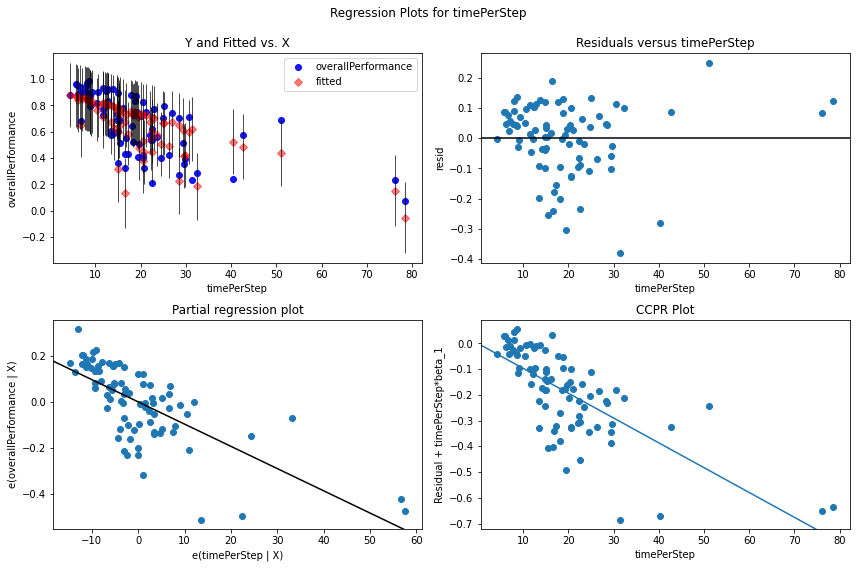

In [78]:
runLinRegAndVisual(analyticsDF, 
                   ["timePerStep", "hintRequested"], 
                   "overallPerformance") 

                            OLS Regression Results                            
Dep. Variable:     overallPerformance   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     3.239
Date:                Wed, 10 Aug 2022   Prob (F-statistic):             0.0756
Time:                        14:10:35   Log-Likelihood:                 8.4364
No. Observations:                  84   AIC:                            -12.87
Df Residuals:                      82   BIC:                            -8.011
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6408      0.027     23.427      0.0

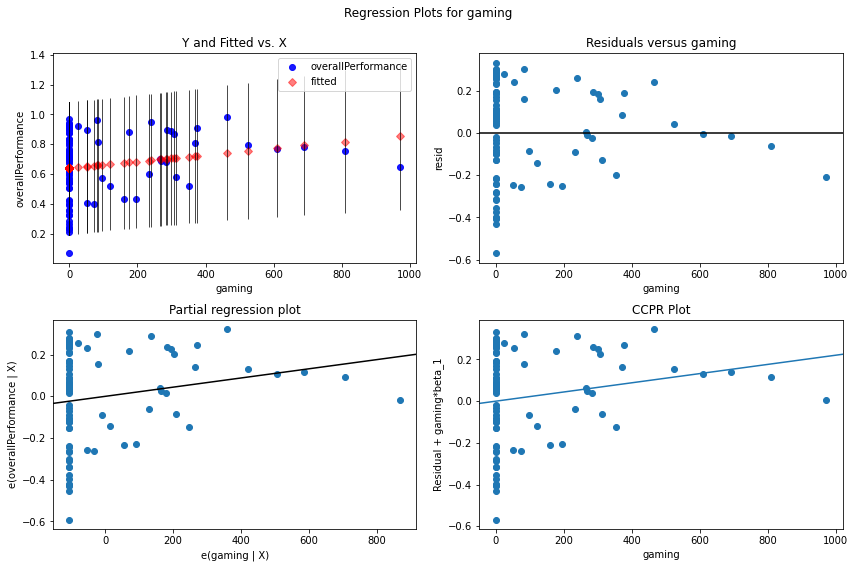

In [77]:
runLinRegAndVisual(analyticsDF, 
                   ["gaming"], 
                   "overallPerformance") 

## 4.2 Predicting Learning Gain 

- Not particularly related to teacher's strategy (Teacher's stop length)

- Negative correlation with `total hand raises` (weak correlation) 

- Positive correlation with `number of problems solved` (strong correlation) 

                            OLS Regression Results                            
Dep. Variable:           learningGain   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     4.288
Date:                Wed, 10 Aug 2022   Prob (F-statistic):             0.0428
Time:                        14:34:50   Log-Likelihood:                 23.229
No. Observations:                  60   AIC:                            -42.46
Df Residuals:                      58   BIC:                            -38.27
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0110      0.049     -0.

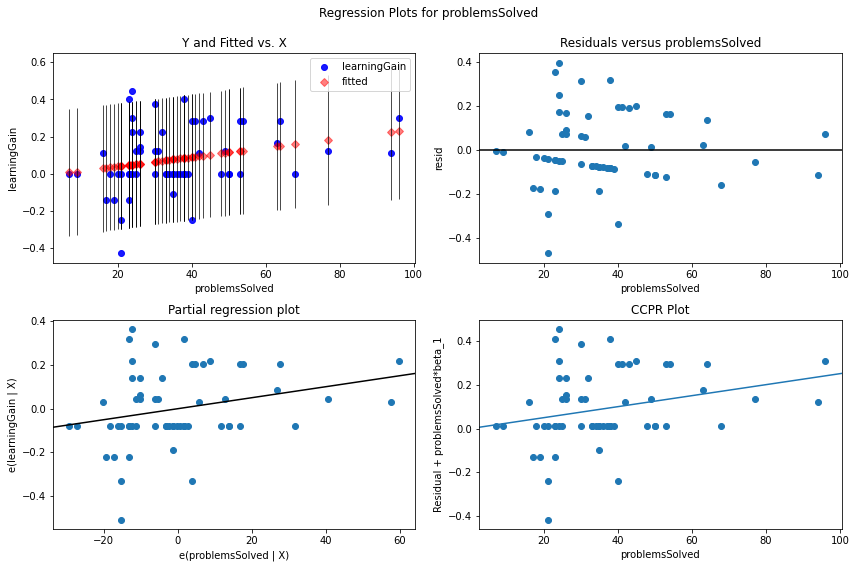

In [90]:
runLinRegAndVisual(analyticsDF, 
                   ["problemsSolved"], 
                   "PlearningGain", visualXName="problemsSolved") 


                            OLS Regression Results                            
Dep. Variable:          ClearningGain   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     8.795
Date:                Wed, 10 Aug 2022   Prob (F-statistic):            0.00438
Time:                        21:58:18   Log-Likelihood:                -40.138
No. Observations:                  60   AIC:                             84.28
Df Residuals:                      58   BIC:                             88.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0452      0.074      0.615

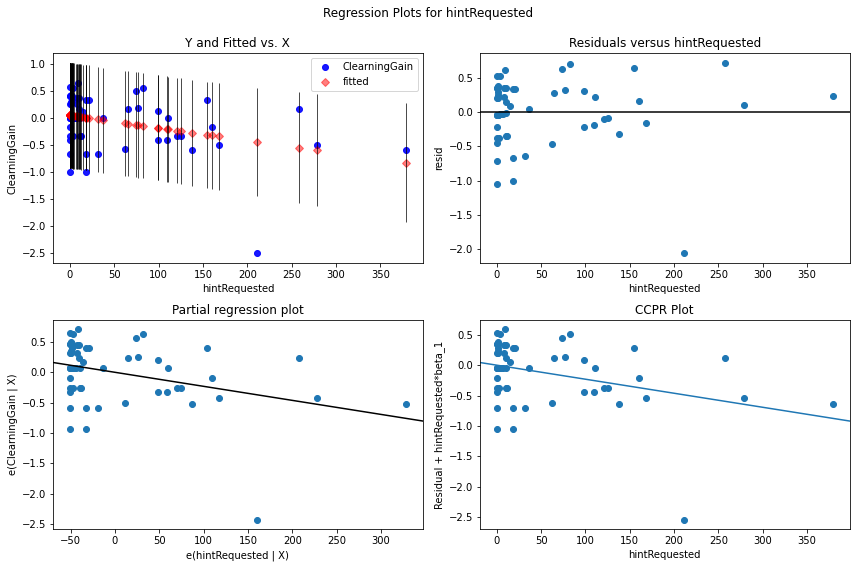

In [106]:
runLinRegAndVisual(analyticsDF, 
                   ["hintRequested"], 
                   "ClearningGain" ) 

## 4.3 Relationship Between Student Help-Seeking Behavior and Teacher Strategy

- Number of on- and off- task visits has significant relationship with `number of hand raises` 

- Students' help seeking behavior does not panetrate through modalities and connect with teacher's stop length 

                            OLS Regression Results                            
Dep. Variable:        totalStopLength   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.604
Date:                Tue, 09 Aug 2022   Prob (F-statistic):              0.209
Time:                        16:43:42   Log-Likelihood:                -440.28
No. Observations:                  84   AIC:                             884.6
Df Residuals:                      82   BIC:                             889.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          45.4265      6.764     

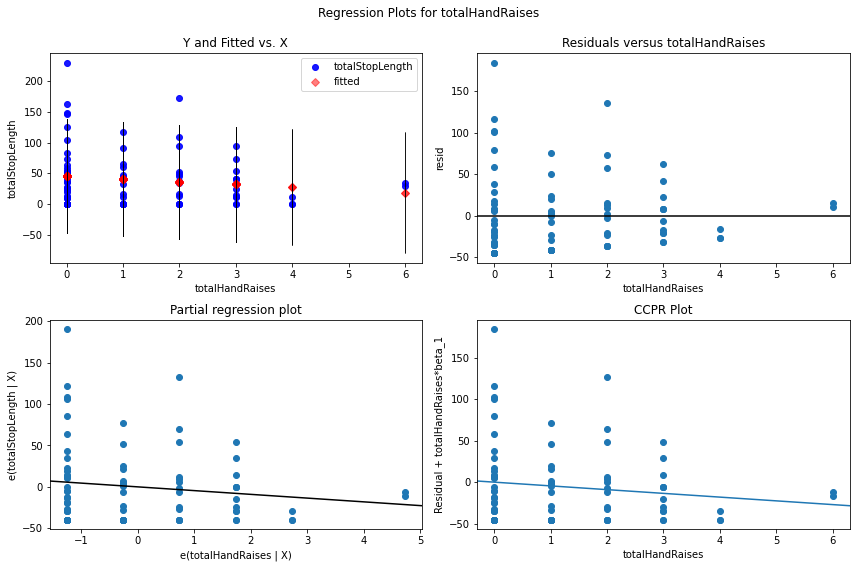

In [60]:
runLinRegAndVisual(analyticsDF, 
                   ["totalHandRaises"], 
                   "totalStopLength") 

                            OLS Regression Results                            
Dep. Variable:        totalHandRaises   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     19.41
Date:                Tue, 09 Aug 2022   Prob (F-statistic):           3.16e-05
Time:                        16:30:31   Log-Likelihood:                -139.44
No. Observations:                  84   AIC:                             282.9
Df Residuals:                      82   BIC:                             287.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

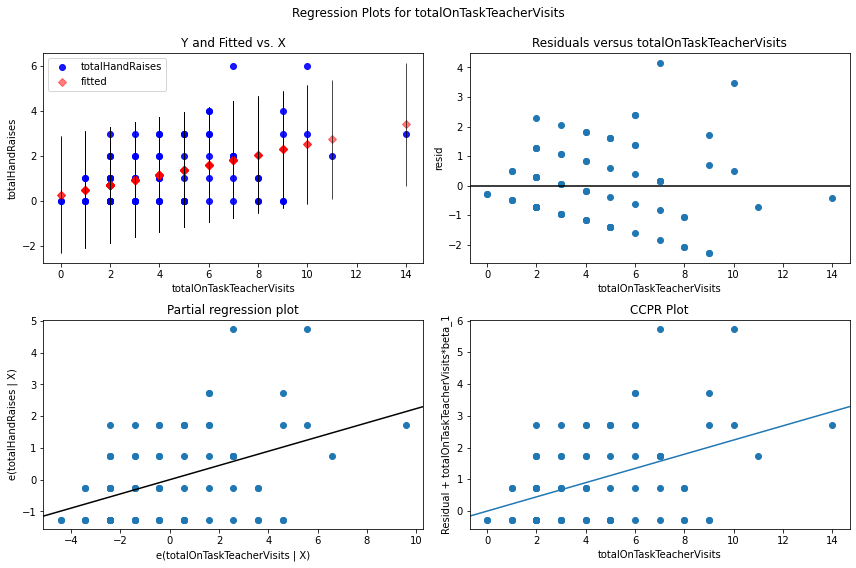

In [50]:
runLinRegAndVisual(analyticsDF, 
                   ["totalOnTaskTeacherVisits"], 
                   "totalHandRaises") 

                            OLS Regression Results                            
Dep. Variable:        totalHandRaises   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     12.15
Date:                Tue, 09 Aug 2022   Prob (F-statistic):           0.000791
Time:                        16:35:13   Log-Likelihood:                -142.56
No. Observations:                  84   AIC:                             289.1
Df Residuals:                      82   BIC:                             294.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

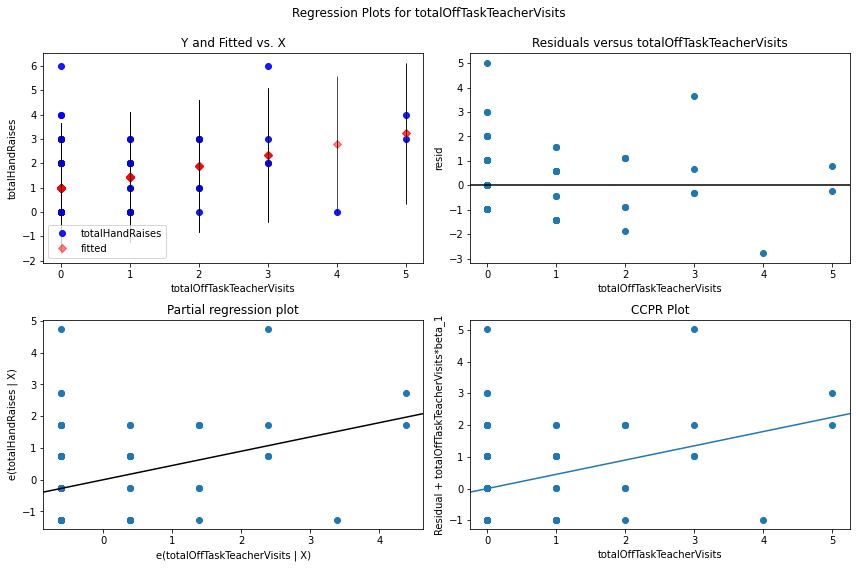

In [54]:
runLinRegAndVisual(analyticsDF, 
                   ["totalOffTaskTeacherVisits"], 
                   "totalHandRaises") 

                            OLS Regression Results                            
Dep. Variable:        totalStopLength   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     11.74
Date:                Wed, 10 Aug 2022   Prob (F-statistic):           3.34e-05
Time:                        14:47:53   Log-Likelihood:                -430.40
No. Observations:                  84   AIC:                             866.8
Df Residuals:                      81   BIC:                             874.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

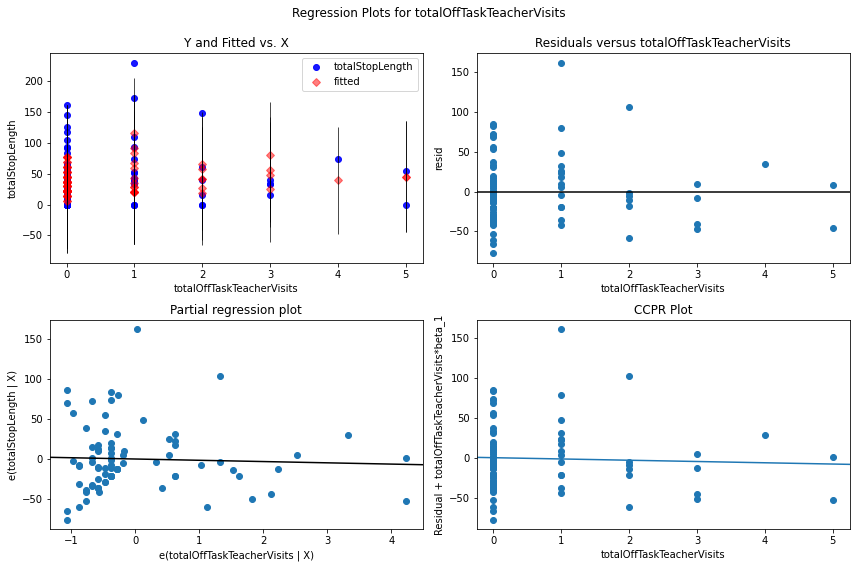

In [95]:
runLinRegAndVisual(analyticsDF, 
                   ["totalOffTaskTeacherVisits", "totalOnTaskTeacherVisits"], 
                   "totalStopLength") 

## 4.4 Predicting Student Engagement Behavior 

                            OLS Regression Results                            
Dep. Variable:                   idle   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     2.819
Date:                Tue, 09 Aug 2022   Prob (F-statistic):             0.0655
Time:                        16:52:50   Log-Likelihood:                -544.38
No. Observations:                  84   AIC:                             1095.
Df Residuals:                      81   BIC:                             1102.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

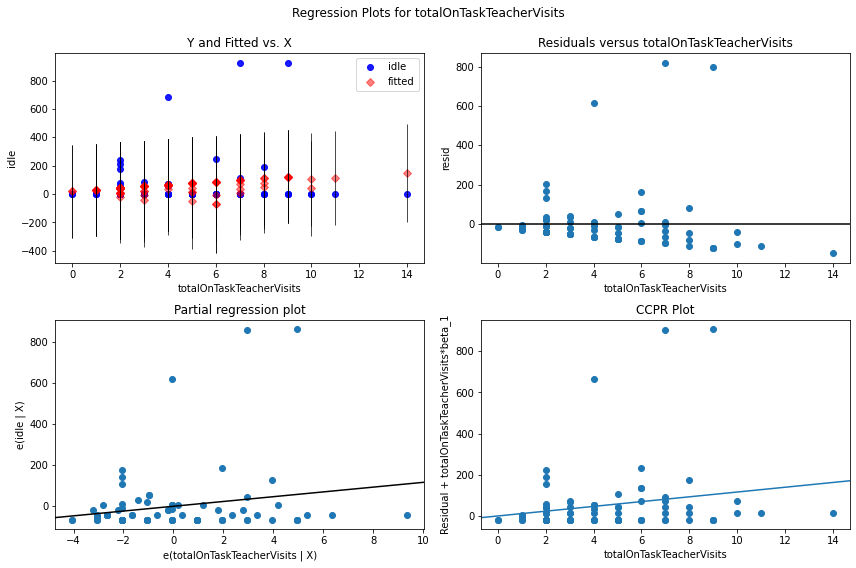

In [64]:
runLinRegAndVisual(analyticsDF, 
                   ["totalOnTaskTeacherVisits", "totalOffTaskTeacherVisits"], 
                   "idle") 

                            OLS Regression Results                            
Dep. Variable:               struggle   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.6335
Date:                Wed, 10 Aug 2022   Prob (F-statistic):              0.640
Time:                        15:00:31   Log-Likelihood:                -521.90
No. Observations:                  84   AIC:                             1054.
Df Residuals:                      79   BIC:                             1066.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

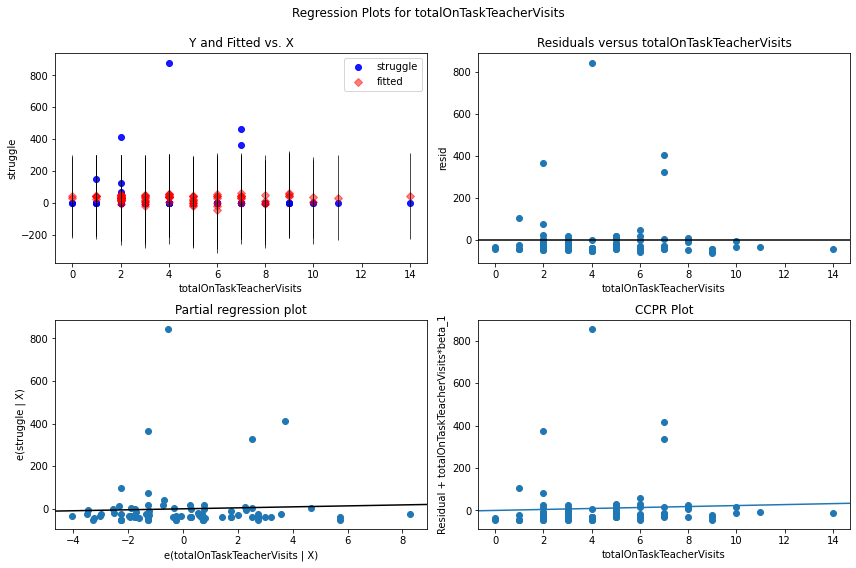

In [98]:
runLinRegAndVisual(analyticsDF, 
                   ["totalOnTaskTeacherVisits", "totalOffTaskTeacherVisits", "totalStopLength", "stopsLengthMean"], 
                   "struggle") 